In [80]:
"""Run this notebook from the repo root."""

'Run this notebook from the repo root.'

In [81]:
import os

os.chdir(r"C:\Users\zvfrf\PycharmProjects\meta-automl-research")

In [82]:
import torch

from torch_geometric.loader import DataLoader

from surrogate.datasets import HomogeneousPipelineDataset
from surrogate.models import HomogeneousGCN
import matplotlib.pyplot as plt
import numpy as np

In [83]:
model = HomogeneousGCN.load_from_checkpoint(
    r"C:\Users\zvfrf\PycharmProjects\meta-automl-research\experiments\reproduce_nir_cherniak_with_new_data\version_0\checkpoints\last.ckpt",
    name="HomogeneousGCN",
    model_parameters={
        "in_channels": 15,
        "out_channels": 1,
        "gnn_hidden_channels": 8,
        "gnn_num_layers": 3,
        "mlp_hidden_channels": 8,
        "mlp_num_layers": 2,
        "aggregation": "sum",
        "clip_output": None,
    },
    loss_name="mse_loss",
    lr=1e-3,
)
model = model.eval()

In [84]:
dataset = HomogeneousPipelineDataset(
    root="C:\\Users\\zvfrf\\PycharmProjects\\meta-automl-research\\data\\knowledge_base_v0_homogeneous_dataset_train",
    split=None,  # Dataset is divided into train/test folders.
    direction="undirected",
    use_operations_hyperparameters=False,
    overriden_processed_dir="C:\\Users\\zvfrf\\PycharmProjects\\meta-automl-research\\data\\knowledge_base_v0_homogeneous_dataset_all\\processed",
)
loader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=False,
)

In [85]:
preds = []
fitness = []
for batch in iter(loader):
    x, fitness_value = batch
    with torch.no_grad():
        pred = model.model(x).numpy()
    pred_scaled_back = dataset._metrics_scaler.inverse_transform(pred)
    fitness_scaled_back = dataset._metrics_scaler.inverse_transform(fitness_value)
    fitness.append(fitness_scaled_back)
    preds.append(pred_scaled_back)

In [86]:
pred_fitness = np.vstack(preds).T
fitness = np.vstack(fitness).T

In [87]:
from scipy.stats import kendalltau

gt_ranking = np.flip(np.argsort(fitness))
pred_ranking = np.flip(np.argsort(pred_fitness))

print(f"Kendall-tau correlation: {kendalltau(gt_ranking, pred_ranking)}")

Kendall-tau correlation: SignificanceResult(statistic=0.178822994773915, pvalue=0.000703571564684826)


In [88]:
from surrogate.metrics import ndcg

print(f"NDCG: {ndcg(fitness, pred_fitness)}")

NDCG: 1.0242771399511725


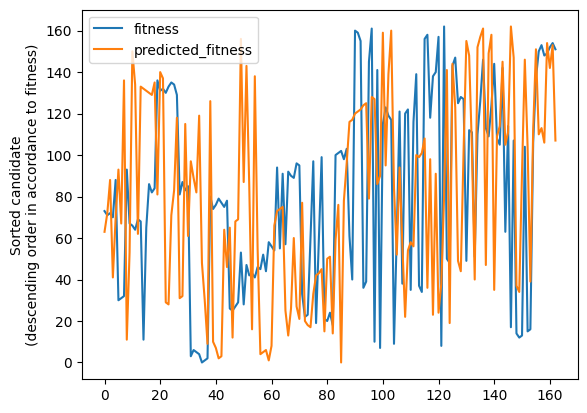

In [89]:
plt.plot(gt_ranking.squeeze(0), label="fitness")
plt.plot(pred_ranking.squeeze(0), label="predicted_fitness")
plt.legend()
plt.ylabel("Sorted candidate\n(descending order in accordance to fitness)")
plt.show()

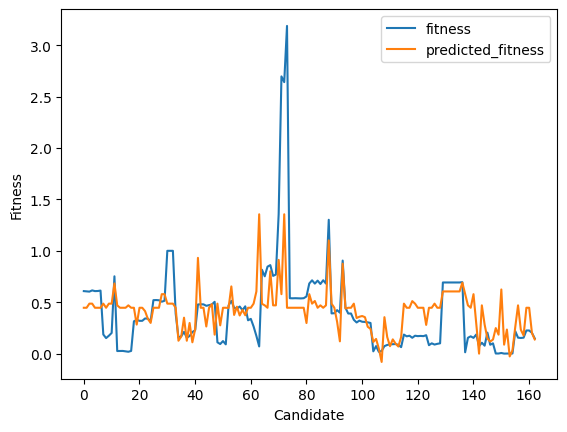

In [90]:
plt.plot(fitness.squeeze(0), label="fitness")
plt.plot(pred_fitness.squeeze(0), label="predicted_fitness")
plt.legend()
plt.xlabel("Candidate")
plt.ylabel("Fitness")
plt.show()